# Sell Naked Put Strategy 2.0

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#from pandas_datareader import data as pdr
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf
from scipy.stats import skew

Delta di tempo consigliato: 1/2 anni

Formato data: anno-mese-giorno

In [36]:
start = dt(2010,1,1)
end = dt.today()

In [37]:
#spx = web.DataReader('^GSPC', 'yahoo', start = '2020-11-26', end = '2022-12-16')
spx = yf.download("^GSPC", start=start, end=end)
spx = np.round(spx['Close'])

spx_ret = np.log(spx/spx.shift(1)).dropna()

vix = yf.download("^VIX", start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


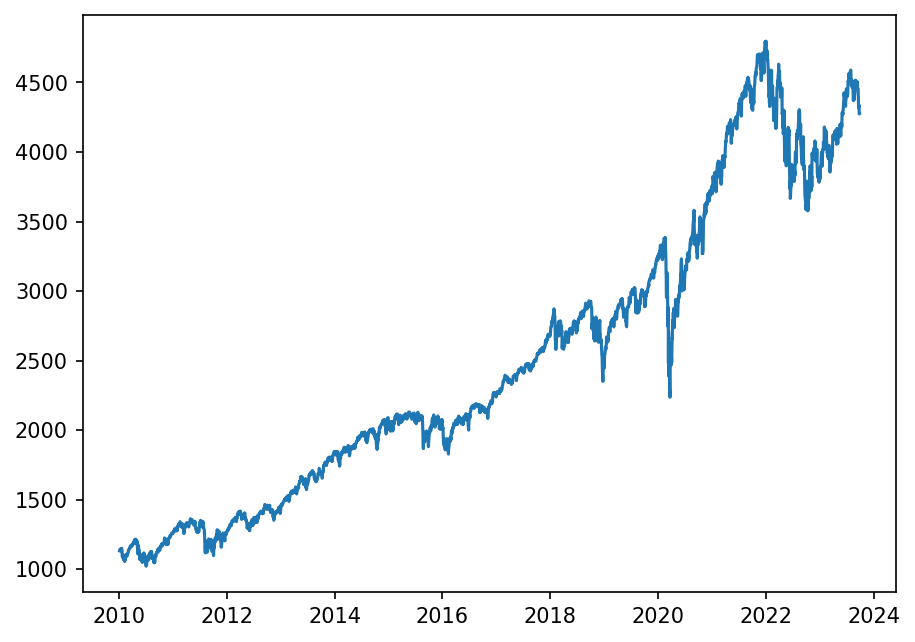

In [38]:
figure(figsize=(7, 5), dpi=150)
plt.plot(spx)

In [39]:
def deltaStrikeITM(spx):
    dist = []
    for t in range(len(spx)-21):
        if(spx[t+21]<=spx[t]):
            dist.append(abs( (spx[t+21]/spx[t])-1 ))
        else:
            dist.append(0)
    return dist

The deltaStrikeITM function calculates the difference between the price on day t and the price on day t+1 (which is one month later), but only if the price on day t+1 is less than or equal to the price on day t.

In [40]:
dif1 = deltaStrikeITM(spx)
#Aggiorno dif1 togliendo gli zeri
dif1_up = [value for value in dif1 if value != 0]

C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\1351650072.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(spx[t+21]<=spx[t]):
C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\1351650072.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist.append(abs( (spx[t+21]/spx[t])-1 ))


1) In the first bar plot, we can see on the Y-axis all the previously calculated deltas. The bar is set to 0 if the put option was out of the money (OTM) in the following month.

2) The second chart displays the time series of the VIX: Volatility Index from the Chicago Board Options Exchange, a popular measure of the stock market's expected volatility based on S&P 500 index options.

3) The third chart shows the histogram of the deltas, excluding zeros.

C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\2584802549.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(x=pd.Series(dif1_up).describe()[3], linewidth=2, color='r') # min
C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\2584802549.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(x=pd.Series(dif1_up).describe()[4], linewidth=2, color='b') # 1t quartile 25%
C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\2584802549.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

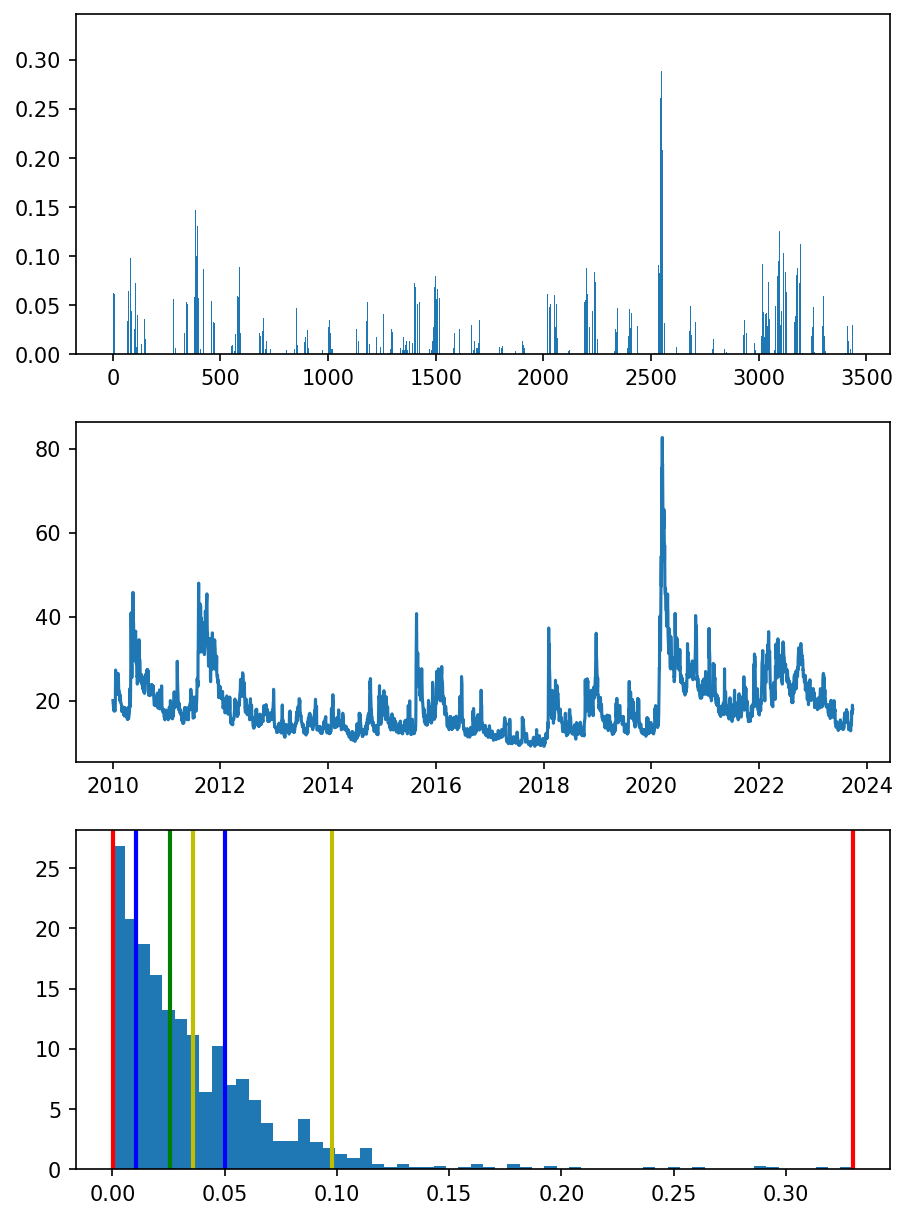

In [41]:
figure(figsize=(7, 10), dpi=150)
plt.subplot(311)
plt.bar(np.arange(1,len(dif1)+1), dif1)

plt.subplot(312)
plt.plot(vix['Close'])

plt.subplot(313)
plt.hist(dif1_up, density=True, bins=60)
plt.axvline(x=pd.Series(dif1_up).describe()[3], linewidth=2, color='r') # min
plt.axvline(x=pd.Series(dif1_up).describe()[4], linewidth=2, color='b') # 1t quartile 25%
plt.axvline(x=pd.Series(dif1_up).describe()[1], linewidth=2, color='y') # mean
plt.axvline(x=pd.Series(dif1_up).describe()[5], linewidth=2, color='g') # median value distribution 50%
plt.axvline(x=pd.Series(dif1_up).describe()[6], linewidth=2, color='b') # 3rd quartile 75%
plt.axvline(x=np.percentile(dif1_up, 95), linewidth=2, color='y') # 95th percentile
plt.axvline(x=pd.Series(dif1_up).describe()[7], linewidth=2, color='r') # max

#Come possiamo osservare in prossimita delle barre verticali abbiamo segli spike nel VIX, tendenzialmente la volatilità aumenta
#con ritorni negativi dell'indice.

In [42]:
mean_dif1_up = np.round(np.mean(dif1_up), 4)
print(f'Mean of the deltas rounded up (excluding zeros): {mean_dif1_up}')

Mean of the deltas rounded up (excluding zeros): 0.0361


In [43]:
pd.Series(dif1_up).describe()

count    1139.000000
mean        0.036075
std         0.037980
min         0.000213
25%         0.010552
50%         0.025651
75%         0.050319
max         0.329838
dtype: float64

In [44]:
#Scarico l'ultimo Close price dell'SP500
price_today = yf.download('^GSPC', start = end - timedelta(days=1), end=dt.today())
price_today = np.round(price_today['Close'][0])
print('Current SP500 quote:',price_today)

[*********************100%%**********************]  1 of 1 completed
Current SP500 quote: 4275.0


C:\Users\e.ceglia\AppData\Local\Temp\ipykernel_13584\3063820431.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_today = np.round(price_today['Close'][0])


By rounding down the current SP500 quote and subtracting the mean of the deltas (rounded up), we can identify an initial strike price at which to short put options. However, this strike price could be fairly risky.

In [45]:
print('Strike price:', np.round(price_today - price_today*mean_dif1_up, 2))

Strike price: 4120.67


For a less risky approach, we can subtract the value rounded up from the 95th percentile of the distribution.

In [46]:
perc95_dif1_up = np.round(np.percentile(dif1_up, 95), 4)
print('95 esimo percentile arrotondato per eccesso:', perc95_dif1_up)

95 esimo percentile arrotondato per eccesso: 0.0978


The 95th percentile of the distribution encompasses 95% of the put options that have gone into the money over the considered time frame. By subtracting this value from the current SP500 price, we position ourselves in the top 5% of the distribution, thereby ensuring a much less risky position.

In [47]:
print('Strike price:', np.round(price_today - price_today*perc95_dif1_up, 2))

Strike price: 3856.9
